## 確率分布のサンプリング


In [1]:
; cl-waffeを読み込む
(load "../../cl-waffe.asd")
(ql:quickload `(:cl-waffe :clgplot) :silent t)

T

(:CL-WAFFE :CLGPLOT)

Unable to find framework CUDA


In [2]:
(defpackage :distribution-example
    (:use :cl :cl-waffe :clgplot :mgl-mat))

(in-package :distribution-example)

#<PACKAGE "DISTRIBUTION-EXAMPLE">

#<PACKAGE "DISTRIBUTION-EXAMPLE">

In [3]:
#+sbcl(declaim (sb-ext:muffle-conditions sb-kernel:redefinition-warning))

((#<SB-KERNEL::CONDITION-CLASSOID SB-KERNEL:REDEFINITION-WARNING>
  . MUFFLE-WARNING))

SB-INT:SIMPLE-STYLE-WARNING: DECLAIM where DECLARE was probably intended


In [21]:
; Utils

(defparameter *output-dir* nil)

(defmacro with-gnuplot (title &body body)
    `(let ((*output-dir* (format nil "./tmp/~a.png" ,title)))
          (locally ,@body)
          (jupyter:file *output-dir* :display t)))

(defun show-tensor (samples pdf &key (sample-n 30) (title "tmp"))
    "samples : サンプリングされた確率分布
     PDF     : 確率密度関数"
    (declare (type waffetensor samples)
             (type function pdf))
    (with-facets ((a* ((data samples) 'array)))
        (plot-histogram-with-pdf
         (coerce a* 'list)
         sample-n
         pdf
         :output *output-dir*
         )))

*OUTPUT-DIR*

WITH-GNUPLOT

SHOW-TENSOR

SB-KERNEL:REDEFINITION-WITH-DEFMACRO: redefining DISTRIBUTION-EXAMPLE::WITH-GNUPLOT in DEFMACRO
SB-INT:SIMPLE-STYLE-WARNING: The variable TITLE is defined but never used.


## 正規分布

確率密度関数 (σは分散, μは平均)

$$
f(x)=\dfrac{1}{\sqrt{2\pi\sigma^2}}\exp(-\dfrac{(x-\mu)^ 2}{2\sigma^ 2})
$$

In [22]:

; single-floatで計算する
(defparameter pi-single-float (coerce pi 'single-float))

; 正規分布の確率密度関数
(defun standard-distribution (x &key (mean 0.0) (var 1.0))
    (declare (optimize (speed 3))
             (type single-float x mean var))
    (* (/ (sqrt (* 2 pi-single-float (expt var 2))))
       (exp (- (/ (expt (- x mean) 2) (* 2 (expt var 2)))))))

PI-SINGLE-FLOAT

STANDARD-DISTRIBUTION

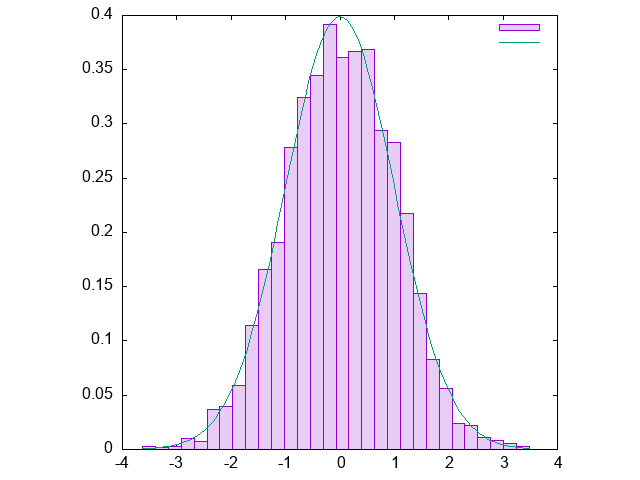

In [27]:
(with-gnuplot "randn"
    (show-tensor (!randn `(3000))
                 #'standard-distribution
                 :title "randn"))